<a href="https://www.kaggle.com/code/shriyapr/text-summary-with-reddit-mental-health-posts?scriptVersionId=137992531" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Text Summary With Reddit Mental Health Posts #
---
# 📈 About the Dataset

* The dataset includes 500 reddit posts, each tagged with a severity score on the Columbia-Suicide Severity Rating Scale. The scale ranges from a rating of "supportive" to "attempt". This dataset allows the observer to easily recognize which posts are the most severe to encourage targetted suicide prevention. 

# 🔬 Research

* The original goal was to create a predictive model to classify inputted text into one of the 5 C-SSRS categories, but none of the models resulted in a viable accuracy score. Therefore, we decided to use extractive and abstractive text summarization to return a condensed version of each post. Using text summarization models, professionals can easily scan large excerpts of text to recognize who needs care urgently, and overall, improve suicide prevention efforts online.

---
# 1.  🧹 Cleaning the Data

In [1]:
#install packages
!pip install nltk
!pip install neattext
!pip install contractions
!pip install transformers
!pip install transformers torch
!pip install wordcloud
!pip install scikit-learn
!pip install pandas
!pip install numpy

#load packages
import nltk
import pandas as pd
#tools for dataframe
from pandas import DataFrame
#tools for text preprocessing
import re
import neattext as nt

#plotting
from matplotlib import matplotlib_fname

#model
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from xml.sax.saxutils import XMLFilterBase
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#extractive summarization
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#original summary
from transformers import BartTokenizer, BartForConditionalGeneration
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Tools to remove stopwords
from nltk.corpus import stopwords

# Tools for tokenizing
from nltk.tokenize.toktok import ToktokTokenizer

# Tools for lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#Package to help us expand contractions
import contractions

# Tools for plotting
import matplotlib.pyplot as plt

# Tools for doing word frequencies
from nltk.util import ngrams

#wordcloud
from wordcloud import WordCloud

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

     |████████████████████████████████| 114 kB 13.0 MB/s 
     |████████████████████████████████| 101 kB 4.9 MB/s 
     |████████████████████████████████| 289 kB 60.0 MB/s 


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [2]:
#define functions
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_special_characters2(text, remove_digits=True):
    if not remove_digits:
        # Match any character that is not a lowercase or uppercase letter, digit, whitespace, or punctuation at the end of a sentence.
        pattern = r'[^a-zA-Z0-9\s.!?]'
    else:
        # Match any character that is not a lowercase or uppercase letter, whitespace, or punctuation at the end of a sentence.
        pattern = r'[^a-zA-Z\s.!?]'
    text = re.sub(pattern, '', text)
    return text

#stopwords
print(stopwords.words('english'))

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.append('http') # we will remove 'http' from texts
stopword_list.append('hyperactive') # we will reomve 'hyperactive' from texts
stopword_list.append(']') # we will reomve ']' from texts

def remove_stopwords(text, is_lower_case=False):
    # First, tokenize the text
    tokens = tokenizer.tokenize(text)
    # remove whitespaces in each token
    tokens = [token.strip() for token in tokens]
    # if "is_lower_case" parameter is True,
    # we will not remove stopwords that have any upper case letter
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    # If "is_lower_case" parameter is False,
    # we will remove any stopwords no matter whether they are in uppercase or not
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#lemmatize
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    s = " " # create an empty string that later will contain lemmatized words,
    t_l = [] # create an empty list
    t_w = nltk.word_tokenize(text) # tokenize the text
    # assign the list of tokenized words into t_w.
    for w in t_w:
        # “pos” is a part of speech parameter and “v” means verbs.
        # We will lemmatize verbs only.
        l_w = wordnet_lemmatizer.lemmatize(w, pos="v")
        # append l_w into the list t_l
        t_l.append(l_w)
    # joint the tokens to make a complete sentence
    text = s.join(t_l)
    return text

def normalize_corpus(corpus, text_lower_case=True,
                     text_lemmatization=True, special_char_removal=True,
                     stopword_removal=True, remove_digits=True):
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # lowercase the text
        if text_lower_case:
            doc = doc.lower()
        doc = contractions.fix(doc)  #Make contractions into full form
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        doc = re.sub('`', '', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)

        normalized_corpus.append(doc)

    return normalized_corpus

def extract_emotional_words(text):
  sia = SentimentIntensityAnalyzer()
  words = nltk.word_tokenize(text.lower())
  emotional_words = set(word for word in words if sia.polarity_scores(word)["compound"] != 0)
  return emotional_words

def set_to_string(s):
  seperator = ', '
  return seperator.join(str(x) for x in s)

def extractive_summarization(text, num_sentences = 3):
  #tokenize the text into sentences
  sentence = sent_tokenize(text)

  #make each sentence a vector
  vectorizer = CountVectorizer().fit_transform(sentence)

  #use cosine similarity to calculate sentence similarity
  sentence_similarity = cosine_similarity(vectorizer)

  #rank sentences on similarity
  scores = sentence_similarity.sum(axis=1)
  ranked_sentences = [sentence[i] for i in scores.argsort()[-num_sentences:][::-1]]

  return " ".join(ranked_sentences)

def create_summary(text):
  inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation = True)
  summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams= 4, early_stopping=True)
  summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  return summary

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [3]:
#locate data
import os
for dirname, _, filenames in os.walk('/kaggle/input/c-ssrs-labeled-suicidality-in-500-anonymized-red'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/c-ssrs-labeled-suicidality-in-500-anonymized-red/500_anonymized_Reddit_users_posts_labels - 500_anonymized_Reddit_users_posts_labels.csv


In [4]:
#read in csv file
data = pd.read_csv('/kaggle/input/c-ssrs-labeled-suicidality-in-500-anonymized-red/500_anonymized_Reddit_users_posts_labels - 500_anonymized_Reddit_users_posts_labels.csv')

In [5]:
#delete user column
data = data.iloc[:, 1:]
#rename columns
data.columns = ("post", "label")
#view data
data

,post,label
0,"['Its not a viable option, and youll be leavin...",Supportive
1,['It can be hard to appreciate the notion that...,Ideation
2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,['I tried to kill my self once and failed badl...,Attempt
4,['Hi NEM3030. What sorts of things do you enjo...,Ideation
...,...,...
495,"['Its not the end, it just feels that way. Or ...",Supportive
496,"['It was a skype call, but she ended it and Ve...",Indicator
497,['That sounds really weird.Maybe you were Dist...,Supportive
498,['Dont know there as dumb as it sounds I feel ...,Attempt


In [6]:
#%% Normalize the text data and add a new column on the csv file of the preprocessed text
data['normalized_text'] = normalize_corpus(data['post'])

In [7]:
#remove first character
data["normalized_text"] = data['normalized_text'].str[1:]
#remove last character
data["normalized_text"] = data['normalized_text'].str[:-1]

In [8]:
#extract keywords
data['keywords'] = data['normalized_text'].apply(extract_emotional_words)
data['keywords'] = data['keywords'].apply(set_to_string)

In [9]:
#create column with normalized keywords
data['normalized_keywords'] = data['keywords'].apply(nt.remove_punctuations)

In [10]:
#view how many posts for each category
groups = data.groupby('label').agg({'label':'count'})
groups

,label
label,
Attempt,45
Behavior,77
Ideation,171
Indicator,99
Supportive,108


In [11]:
#narrow categories down and save to new_labels
category_mapping = {
    'Supportive': 'Supportive',
    'Indicator': 'Ideation',
    'Ideation': 'Ideation',
    'Behavior': 'Behavior',
    'Attempt': 'Behavior'
}
data['new_labels'] = data['label'].replace(category_mapping)
data

,post,label,normalized_text,keywords,normalized_keywords,new_labels
0,"['Its not a viable option, and youll be leavin...",Supportive,viable option leave wife behind would pain be...,"hand, positive, worry, pressure, shit, definit...",hand positive worry pressure shit definitely p...,Supportive
1,['It can be hard to appreciate the notion that...,Ideation,hard appreciate notion could meet someone els...,"importance, progress, stronger, relax, aversio...",importance progress stronger relax aversion in...,Ideation
2,"['Hi, so last night i was sitting on the ledge...",Behavior,hi last night sit ledge window contemplate wh...,"perfect, play, please, die, like, cut, difficu...",perfect play please die like cut difficult pai...,Behavior
3,['I tried to kill my self once and failed badl...,Attempt,try kill self fail badly moment want realize ...,"perfect, love, stronger, play, shit, aggressiv...",perfect love stronger play shit aggressive suf...,Behavior
4,['Hi NEM3030. What sorts of things do you enjo...,Ideation,hi nem sort things enjoy personally always we...,"brighter, lose, welcome, please, brave, suffer...",brighter lose welcome please brave suffer like...,Ideation
...,...,...,...,...,...,...
495,"['Its not the end, it just feels that way. Or ...",Supportive,end feel way least entire lifetime fix things...,"harm, great, bore, love, stronger, please, str...",harm great bore love stronger please strength ...,Supportive
496,"['It was a skype call, but she ended it and Ve...",Indicator,skype call end ventricular dysfunction leave ...,"rape, like, suicidal, good, dysfunction, kill,...",rape like suicidal good dysfunction kill phobi...,Ideation
497,['That sounds really weird.Maybe you were Dist...,Supportive,sound really weird maybe distractibility some...,"irritable, progress, gift, relax, jealous, des...",irritable progress gift relax jealous desperat...,Supportive
498,['Dont know there as dumb as it sounds I feel ...,Attempt,know dumb sound feel behavior even deserve he...,"love, play, lose, struggle, like, fear, sad, h...",love play lose struggle like fear sad help gee...,Behavior


In [12]:
#save preprocessed text to new csv file
data.to_csv("posts_preprocessed.csv")

# 2. 📊 Exploratory Data Analysis

In [13]:
#view how many posts for each narrowed category
groups2 = data.groupby('new_labels').agg({'new_labels':'count'})
groups2 = groups2.iloc[::-1]
groups2

,new_labels
new_labels,
Supportive,108
Ideation,270
Behavior,122


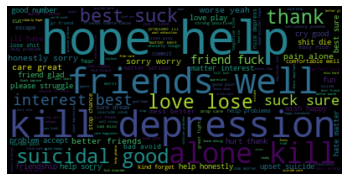

In [14]:
#wordcloud with keywords
column_values = data['normalized_keywords'].tolist()
#concatenate the column values into a single string
concate = ' '.join(column_values)
#create a WordCloud object
word_cloud = WordCloud()
#generate the word cloud from the text
word_cloud.generate(concate)
#display the word cloud using matplotlib
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

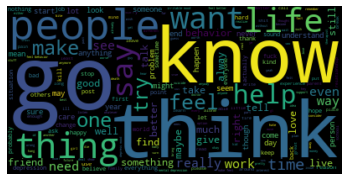

In [15]:
#wordcloud with all normalized words
column_values = data['normalized_text'].tolist()
#concatenate the column values into a single string
concate = ' '.join(column_values)
#create a WordCloud object
word_cloud = WordCloud()
#generate the word cloud from the text
word_cloud.generate(concate)
#display the word cloud using matplotlib
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

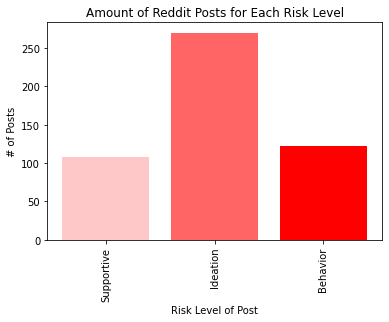

In [16]:
#create the bar graph to count each post
plt.bar(range(3), groups2.new_labels, color=('#FFC8C8', '#FF6565', '#FF0000'))

#add labels and title
plt.xlabel('Risk Level of Post')
plt.ylabel('# of Posts')
plt.title('Amount of Reddit Posts for Each Risk Level')

#change x axis labels
plt.xticks(range(len(groups2)), groups2.index, rotation=90)

#display the graph
plt.show()

Text(0.5, 0, '# of Occurances')

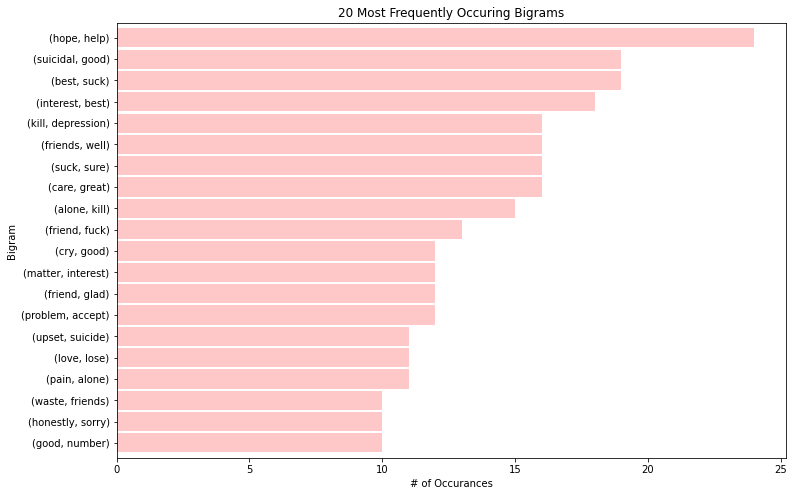

In [17]:
#calculating the bigrams for all the supportive posts
support_posts=[]
for words in data[data.new_labels == 'Supportive'].normalized_keywords:
    tokens = tokenizer.tokenize(words)
    for token in tokens:
        support_posts.append(token)
support_bigrams_series = (pd.Series(nltk.ngrams(support_posts, 2)).value_counts())[:20]

#creating a plot of the number of bigrams for all the supportive posts
support_bigrams_series.sort_values().plot.barh(color='#FFC8C8', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

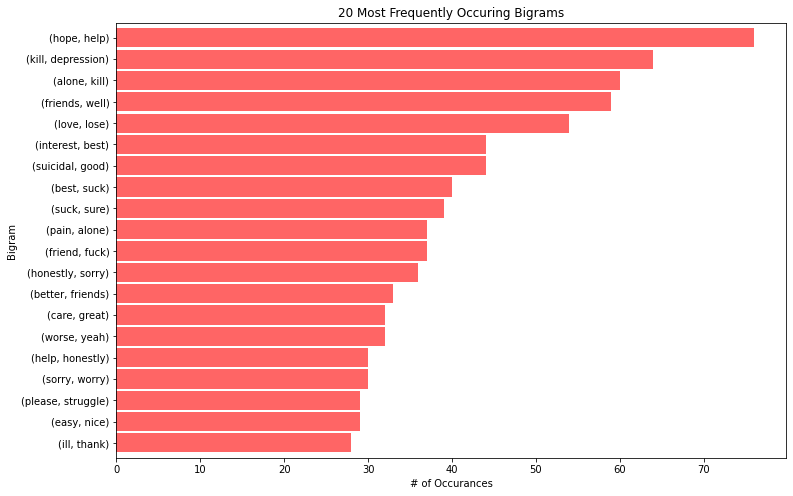

In [18]:
#calculating the bigrams for all the indicator posts
ideation_posts=[]
for words in data[data.new_labels == 'Ideation'].normalized_keywords:
    tokens = tokenizer.tokenize(words)
    for token in tokens:
        ideation_posts.append(token)
ideation_bigrams_series = (pd.Series(nltk.ngrams(ideation_posts, 2)).value_counts())[:20]

#creating a plot of the number of bigrams for all the indicator posts
ideation_bigrams_series.sort_values().plot.barh(color='#FF6565', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

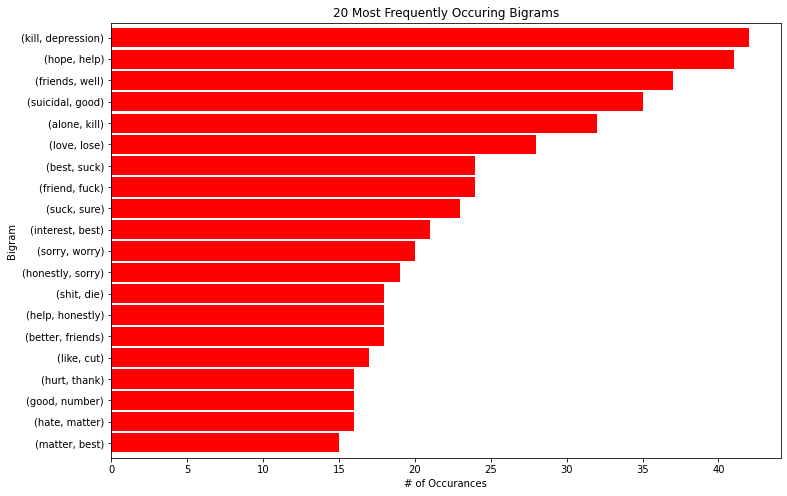

In [19]:
#calculating the bigrams for all the attempt posts
behavior_posts=[]
for words in data[data.new_labels == 'Behavior'].normalized_keywords:
    tokens = tokenizer.tokenize(words)
    for token in tokens:
        behavior_posts.append(token)
behavior_bigrams_series = (pd.Series(nltk.ngrams(behavior_posts, 2)).value_counts())[:20]

#creating a plot of the number of bigrams for all the behavior posts
behavior_bigrams_series.sort_values().plot.barh(color='#FF0000', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

# 3. 🧪 Training and Testing the Predictive Models
* After the exploratory analysis, it was clear there was not a large difference between the words the users used in posts under each of the categories. This was reflected when the models were tested below:

In [20]:
#naive bayes model

# build features from text
XFeatures = data['normalized_keywords']
ylabels = data['new_labels']

cv = CountVectorizer()
X = cv.fit_transform(XFeatures)

cv.get_feature_names()
X.toarray()

#split ds
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size = 0.3, random_state = 42)

#build model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

#accuracy score
nb_model.score(X_test, y_test)

0.46

In [21]:
#try logistic regression

lr_model = LogisticRegression(multi_class = 'multinomial')
lr_model.fit(X_train, y_train)

#accuracy score
lr_model.score(X_test, y_test)

0.4533333333333333

In [22]:
#try Knearestneighbors

knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)

#accuracy score
knn_score = knn.score(X_test, y_test)
print(knn_score)

0.47333333333333333


#### None of the accuracies exceeded 50%
* At this point, we realized that we would need a different approach to best suit the dataset. In our case, text summarization was a viable option because of the length of some of the reddit posts. 

# ✏️ Text Summarization



In [23]:
#extractive summarization

#create column with posts (no special characters other than end of sentence punctuation)
data['clean_posts'] = data['post'].apply(remove_special_characters2)
data['clean_posts']

#condense the posts into 2 sentences
data['summarize'] = data['clean_posts'].apply(extractive_summarization)
data['summarize']

0      It can definitely feel hopeless as you seem to...
1      You have to close the doors to all negativity ...
2      I realize that its difficult to change the min...
3      What i want to tell you is that you can overco...
4      I hope improving a skill will make things brig...
                             ...                        
495    If your thoughts are scaring you you need to b...
496    The reason she was going to kill herself is be...
497    It may not be me but Ive told you my story and...
498    Whats even worse is that I dont know what to d...
499    When considering the sum total of sorrow assoc...
Name: summarize, Length: 500, dtype: object

* #### Next, I attempted abstractive text summarization.
> 
> The following line takes hours to run, so it has been commented out. This line returns  abstractive summaries of the posts and stores the summaries in a new column.
> 
>     data['summarize_2'] = small_data['clean_posts'].apply(create_summary)
> 

* #### Here is a sample of the output:
     
![](https://github.com/mehadatla/heartfailure/assets/137425663/c1427d8a-fa7a-44cc-94c1-d2207272499f)

* #### Original Post (found in row 2, over 11000 characters): 
> "It can be hard to appreciate the notion that you could meet someone else who will make you happy when you are so deeply in love with your boyfriend ... When you open the doors to negative emotion, then it will sap you greatly.Spend some time around your mother. See the positive in your relationship with her. She can teach you a lot. But you have to be willing to learn."
> 
* #### Summarized Text:
> "Bipolar is when you take things to such extremes. If you were just a bit more indifferent about things youd stabilize a great deal. Stop taking drugs and stuff like that if youre taking them but also stop staying up so late. Live a balanced life. Acclimate to that and make it your new norm."

# 4. 📌 Conclusion & Limitations
* After attempting predictive models such as KNN, Naive Bayes, and Logistic Regression, I realized that the dataset required a different approach to produce a viable model. I concluded that professionals can use text summarization to quickly scan through large amounts of text data. By viewing condensed posts, observers will be able to quickly extract whether or not the user's situation requires urgent attention.

* I attempted two types of text summary: abstractive and extractive. Extractive summarization produced quick results, but the sentences returned were not always representative of the posts, or even cohesive. Due to this, I attempted abstractive text summarization. While this approach took large amounts of time to finish running, the sample that was returned seemed like a viable result. 

* In the future, I will apply abstractive summarization models with shorter runtimes that produce more meaningful summaries. With a more efficient model, I hope to make a contribution to large-scale suicide prevention efforts across multiple platforms.